In [1]:
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm

import config
import utility.df
import utility.iolib
import utility.plotlib
from utility.feature import Feature, FeatureCM

#env = sys.argv[1] if len(sys.argv) > 2 else "dev"

In [2]:
# Setup configuration
cfg = config.ResearchConfig
time_format = cfg.CSV_TIME_FORMAT
date_format = cfg.CSV_DATE_FORMAT
cutoff_date = pd.to_datetime(cfg.CUTOFF_DATE, format=cfg.CSV_DATE_FORMAT)

# Retrieve data
df_subspt, df_lesson, df_incomp, df_crclum, df_pupils = utility.iolib.retrieve_data(cfg)
print("Complete loading data for subscription and lesson history!")

Complete loading data for subscription and lesson history!


In [3]:
# Filter data
cutoff_date = pd.to_datetime(cfg.CUTOFF_DATE, format=cfg.CSV_DATE_FORMAT)
first_date_impFromData = df_subspt.subscription_start_date.min()

pupils_toBeRemoved = utility.df.filter_subspt_data(
    df_subspt, first_date_impFromData, cutoff_date, remove_annual_subspt=False)
df_lesson1 = df_lesson[~df_lesson['pupilId'].isin(pupils_toBeRemoved)]
df_incomp1 = df_incomp[~df_incomp['pupilId'].isin(pupils_toBeRemoved)]
df_subspt1 = df_subspt[~df_subspt['pupilId'].isin(pupils_toBeRemoved)]

df_subspt1 = utility.df.compute_customer_month(df_subspt1, cfg)

# Construct dates frame
df_datesFrame = utility.df.construct_dates_frame(df_subspt1, df_lesson1, df_incomp1, cfg)
df_datesFrame.fillna(0, inplace=True)

By the cutoff date 2018-04-20, there are 1234 active subscriptions.
These subscribers shall be removed from the analysis because we have no evidence to know the lifetime of their subscriptions. 

In the first month of dataset starting from 2014-01-01, there are 154 renewal or new subscriptions.
These subscribers shall be removed from the analysis because we have no evidence to show if they renewed or newly joined. 

In summary, there are 1380/5685 subscribers being removed from the dataset in the analysis. 

Calculate customer month in the subscription table.


100%|██████████| 4305/4305 [00:05<00:00, 842.41it/s] 


Construct data-driven dates frame.
The dates frame has already been assigned customer month and saved  in a file. The file has been loaded!


# Features

In [4]:
# Initialise feature obj
ftr = Feature(df_datesFrame)

ftr.add_usageTime(df_lesson1, df_incomp1)
ftr.add_progressions(df_lesson1)
ftr.add_age(df_pupils)
ftr.add_outcome(df_lesson1)
ftr.add_score(df_lesson1, df_incomp1)
ftr.add_hardship(df_lesson1)

+ Add feature: usage time.
+ Add feature: progressions.
+ Add feature: pupils' age.
+ Add feature: outcome.
+ Add feature: score.
+ Add feature: hardship.


# Customer Month Analysis

In [5]:
study_month = 1

ftrCM = FeatureCM(ftr, study_month, df_subspt1)

ftrCM.add_usageTime()
ftrCM.add_progress()
ftrCM.add_age()
ftrCM.add_outcome()
ftrCM.add_score()
ftrCM.add_hardship()   

C:\Users\User\Anaconda3\lib\site-packages\_pytest\fixtures.py:844: DeprecationWarning: The `convert` argument is deprecated in favor of `converter`.  It will be removed after 2019/01.
  params = attr.ib(convert=attr.converters.optional(tuple))
C:\Users\User\Anaconda3\lib\site-packages\_pytest\fixtures.py:846: DeprecationWarning: The `convert` argument is deprecated in favor of `converter`.  It will be removed after 2019/01.
  ids = attr.ib(default=None, convert=_ensure_immutable_ids)


TypeError: __init__() missing 1 required positional argument: 'configuration'

In [6]:
df_whizz = ftrCM.df_whizz_

churner = df_whizz[df_whizz['churn']==1]
nonchurner = df_whizz[df_whizz['churn']==0]

df_whizz.head()

,num_attempt,num_complete,num_incomplete,rate_incomplete_num,churn,customer_month,last_access,usage_complete,usage_incomplete,usage,...,age,rate_assess,rate_pass,rate_fail,rate_fwrd,rate_back,score,ave_stackDepth,ave_help,sum_help
pupilId,,,,,,,,,,,,,,,,,,,,,
655886,12.0,12.0,0.0,0.0,0,1,30,6112.0,0.0,6112.0,...,5.570157,1.000000,0.666667,0.000000,0.000000,0.0,0.884211,1.000000,2.857143,20.0
658323,102.0,102.0,0.0,0.0,0,1,10,20257.0,0.0,20257.0,...,7.532740,0.862745,0.965909,0.295455,0.295455,0.0,0.979624,1.000000,0.372881,22.0
660299,17.0,17.0,0.0,0.0,0,1,29,2694.0,0.0,2694.0,...,9.344285,0.764706,1.000000,0.230769,0.230769,0.0,1.000000,1.000000,0.500000,5.0
660470,47.0,47.0,0.0,0.0,0,1,7,8901.0,0.0,8901.0,...,10.219849,1.000000,0.829787,0.000000,0.000000,0.0,0.876000,1.000000,2.222222,60.0
660512,47.0,47.0,0.0,0.0,0,1,2,21404.0,0.0,21404.0,...,10.839151,1.000000,0.659574,0.000000,0.000000,0.0,0.686551,1.021277,3.206897,93.0


Text(0.5,0,'Usage')

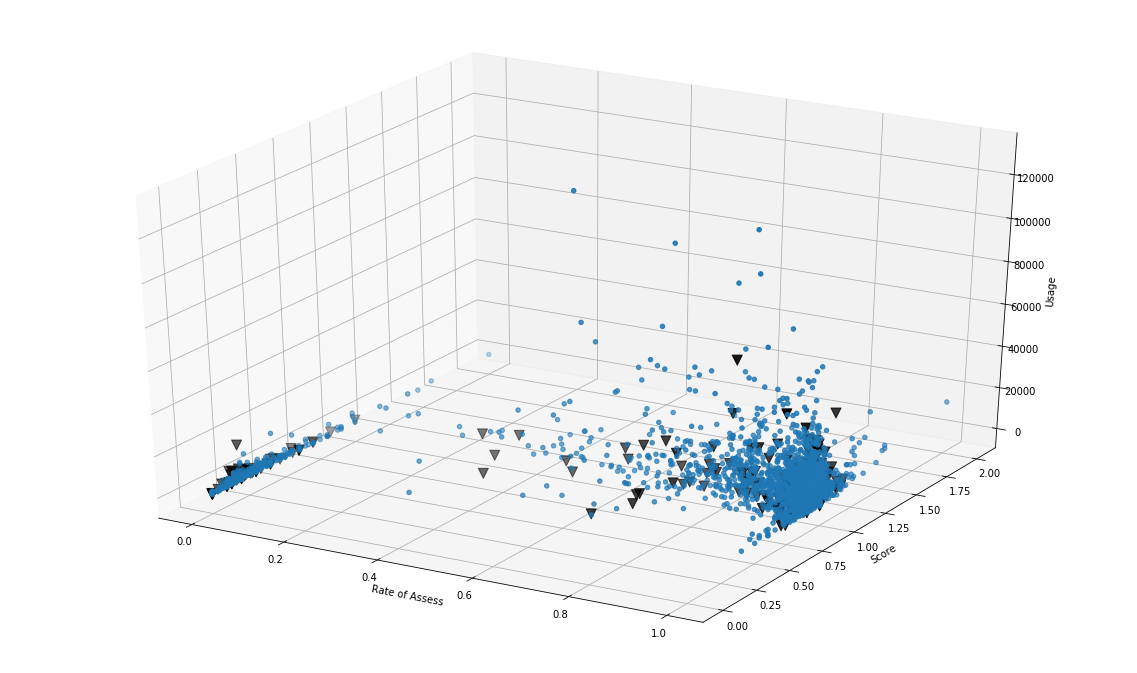

In [7]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(nonchurner.rate_assess, nonchurner.score, nonchurner.usage)
ax.scatter(churner.rate_assess, churner.score, churner.usage, marker='v', s=100, c='k')
ax.set_xlabel('Rate of Assess')
ax.set_ylabel('Score')
ax.set_zlabel('Usage')

#ax.view_init(elev=10, azim=200)

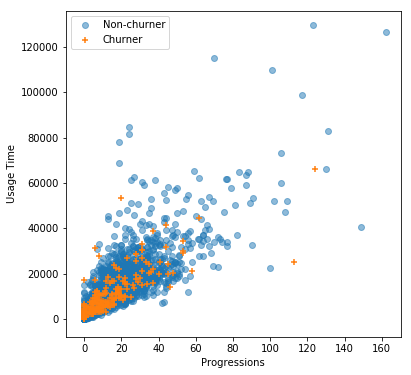

In [8]:
fig = plt.figure(figsize=(6,6))

ax = fig.add_subplot(111)

ax.scatter(nonchurner.progress, nonchurner.usage, alpha=0.5, label='Non-churner')
ax.scatter(churner.progress, churner.usage, marker='+', label='Churner')
ax.set_xlabel('Progressions')
ax.set_ylabel('Usage Time')
#ax.set_xscale('log')
#ax.set_yscale('log')
ax.legend()

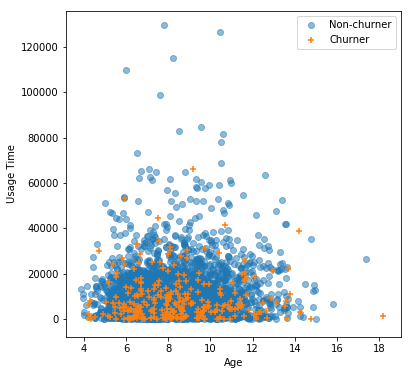

In [9]:
fig = plt.figure(figsize=(6,6))

ax = fig.add_subplot(111)

ax.scatter(nonchurner.age, nonchurner.usage, alpha=0.5, label='Non-churner')
ax.scatter(churner.age, churner.usage, marker='+', label='Churner')
ax.set_xlabel('Age')
ax.set_ylabel('Usage Time')
#ax.set_xscale('log')
#ax.set_yscale('log')
ax.legend()

In [10]:
from sklearn import linear_model

C:\Users\User\Anaconda3\lib\importlib\_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
C:\Users\User\Anaconda3\lib\importlib\_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


In [13]:
import seaborn as sns 

C:\Users\User\Anaconda3\lib\importlib\_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


C:\Users\User\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)


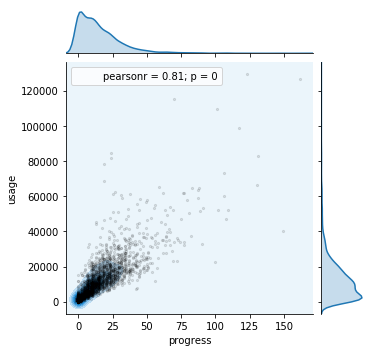

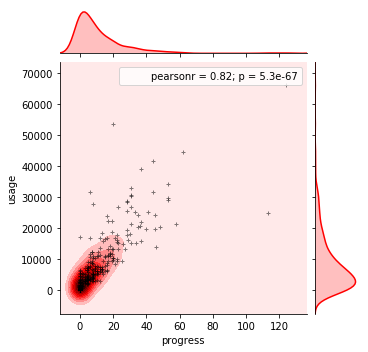

In [14]:
g1 = sns.jointplot(x='progress', y='usage', data=nonchurner[['progress', 'usage']], kind='kde', size=5)
g1.plot_joint(plt.scatter, c="k", s=5, linewidth=1, marker="o", alpha=0.1)

g2 = sns.jointplot(x='progress', y='usage', data=churner[['progress', 'usage']], kind='kde', color='r', size=5)
g2.plot_joint(plt.scatter, c="k", s=10, linewidth=1, marker="+", alpha=0.5)

# Aggregate

In [5]:
df_whizz = pd.DataFrame()

warnings.filterwarnings('ignore')
for cmonth in tqdm(range(1, df_subspt1.customer_month.max()+1)):
    
    ftrCM = FeatureCM(ftr, cmonth, df_subspt1)

    ftrCM.add_usageTime()
    ftrCM.add_progress()
    ftrCM.add_age()
    ftrCM.add_outcome()
    ftrCM.add_score()
    ftrCM.add_hardship()
    
    df = ftrCM.df_whizz_
    
    df_whizz = pd.concat([df_whizz, df], axis=0)
warnings.filterwarnings('default')

100%|██████████| 49/49 [00:13<00:00,  3.76it/s]


In [6]:
df_whizz1 = df_whizz.set_index(['customer_month'], append=True, inplace=False)
df_whizz1 = df_whizz.reset_index()
df_whizz1.set_index(['customer_month', 'pupilId'], inplace=True)
df_whizz1.columns

Index(['num_attempt', 'num_complete', 'num_incomplete', 'rate_incomplete_num',
       'churn', 'last_access', 'usage_complete', 'usage_incomplete', 'usage',
       'rate_incomplete_usage', 'progress', 'age', 'rate_assess', 'rate_pass',
       'rate_fail', 'rate_fwrd', 'rate_back', 'score', 'ave_stackDepth',
       'ave_help', 'sum_help'],
      dtype='object')

C:\Users\User\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)


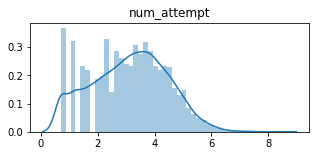

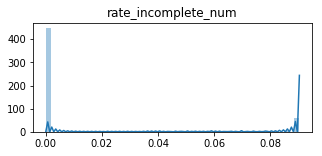

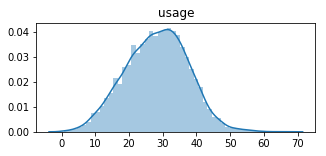

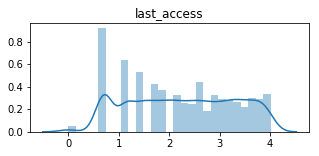

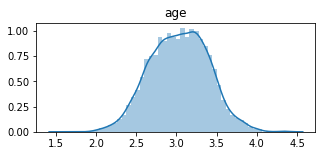

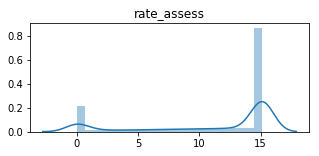

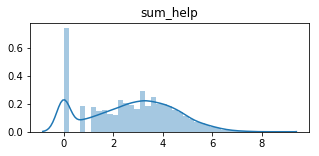

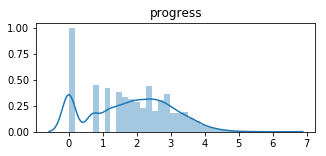

In [58]:
from scipy.stats import boxcox
import seaborn as sns
import mglearn

ftr_list = ['num_attempt',  'rate_incomplete_num', 'usage', 'last_access', 'age', 'rate_assess', 'sum_help', 'progress']
#ftr_list = ['sum_help', 'last_access', 'progress']

X = []
Xt = []

for ftr in ftr_list:
    x = df_whizz1[ftr].values + 1
    xt,_ = boxcox(x)
    X.append(x)
    Xt.append(xt)

X = np.array(X).transpose()
Xt = np.array(Xt).transpose()
y = df_whizz1.churn.values

## SVM

In [59]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=5)

scaler = MinMaxScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

svm = SVC(kernel='sigmoid', C=10, gamma=0.1).fit(X_train_scaled, y_train) # C for regularisation, gamma for width of Gaussian kernel

print('In-sample accuracy: ', svm.score(X_train_scaled, y_train))
print('Out-sample accuracy: ', svm.score(X_test_scaled, y_test))

In-sample accuracy:  0.8838983974708383
Out-sample accuracy:  0.8884892086330936


## Decision Tree

In-sample accuracy:  0.8885860678076966
Out-sample accuracy:  0.8865271419228253
Feature importance:  [0.06281625 0.0308952  0.07206203 0.6272066  0.13092315 0.02849318
 0.01419912 0.03340447]


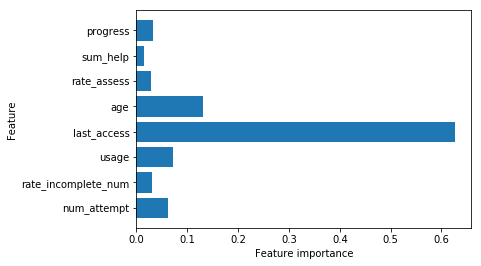

In [80]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(max_depth=5, random_state=0) # the random_state here is used for tie-breaking internally
tree.fit(X_train_scaled, y_train)

print('In-sample accuracy: ', tree.score(X_train_scaled, y_train))
print('Out-sample accuracy: ', tree.score(X_test_scaled, y_test))

print("Feature importance: ", tree.feature_importances_)

def plot_feature_importances(model):
    n_features = X.shape[1]
    plt.barh(range(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), ftr_list)
    plt.xlabel('Feature importance')
    plt.ylabel('Feature')
    
plot_feature_importances(tree)

## Gradient boosted regression trees

In [91]:
from sklearn.ensemble import GradientBoostingClassifier

gbrt = GradientBoostingClassifier(random_state=0, max_depth=1, learning_rate=0.1, n_estimators=1000)
gbrt.fit(X_train_scaled, y_train)

print('In-sample accuracy: ', gbrt.score(X_train_scaled, y_train))
print('Out-sample accuracy: ', gbrt.score(X_test_scaled, y_test))

In-sample accuracy:  0.8855336313092772
Out-sample accuracy:  0.8911052975801177


## Random Forests

In [101]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(n_estimators=100, random_state=0, max_depth=1)
forest.fit(X_train_scaled, y_train)

print('In-sample accuracy: ', forest.score(X_train_scaled, y_train))
print('Out-sample accuracy: ', forest.score(X_test_scaled, y_test))

In-sample accuracy:  0.8838983974708383
Out-sample accuracy:  0.8884892086330936


## Multilayer Perceptrons

In [107]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(solver='lbfgs', random_state=0, hidden_layer_sizes=10).fit(X_train_scaled, y_train)

print('In-sample accuracy: ', mlp.score(X_train_scaled, y_train))
print('Out-sample accuracy: ', mlp.score(X_test_scaled, y_test))

In-sample accuracy:  0.883789381881609
Out-sample accuracy:  0.8884892086330936


KstestResult(statistic=0.11409836624494796, pvalue=9.92905011415437e-139)

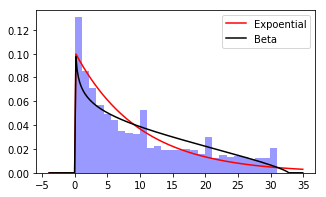

In [75]:
import seaborn as sns
from scipy import stats
from scipy.stats import expon
from scipy.stats import beta
from scipy.stats import poisson

x = df_whizz1.last_access.values

fig = plt.figure(figsize=(5,3))
ax = fig.add_subplot(111)
sns.distplot(x, color='blue', kde=False, fit=expon, fit_kws={"color":"red", 'label':'Expoential'})
sns.distplot(x, hist=False, kde=False, fit=beta, fit_kws={"color":"k", 'label':'Beta'})

ax.legend()

x_size = x.shape[0]

e_loc, e_scale = expon.fit(x)
b_a, b_b, b_loc, b_scale = beta.fit(x)


stats.kstest(x, expon(loc=e_loc, scale=e_scale).cdf)
stats.kstest(x, beta(a=b_a, b=b_b, loc=b_loc, scale=b_scale).cdf)


C:\Users\User\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)


NormaltestResult(statistic=9.285347730964737, pvalue=0.009631908736589938)

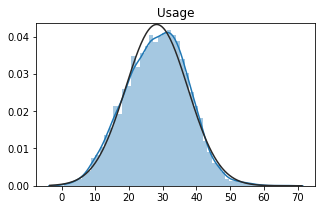

In [79]:
from scipy.stats import norm
from scipy.stats import boxcox

x = df_whizz1.usage.values+1
xt, _ = boxcox(x)

fig = plt.figure(figsize=(5,3))
ax = fig.add_subplot(111)
sns.distplot(xt, fit=norm)
ax.set_title('Usage')

u, s = norm.fit(xt)
stats.kstest(xt, norm(u,s).cdf)

stats.normaltest(xt)


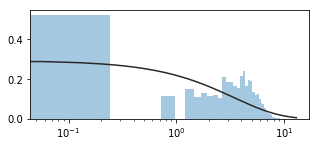